In [70]:
import tensorflow as tf
import os
import time
import numpy as np
physical_devices = tf.config.experimental.list_physical_devices('GPU') 
for physical_device in physical_devices: 
    tf.config.experimental.set_memory_growth(physical_device, True)
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython import display

In [71]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades\\')

In [72]:
def load(image):
    w = image.shape[1]
    w = w // 2
    
    real_image = image[:,:w,:]
    input_image = image[:,w:,:]
    return input_image,real_image

In [73]:
from PIL import Image as pillow
data_x = []
data_y = []
for i in ['test','train']:
    list_dir = os.listdir("{}{}".format(PATH,i))
    data = []
    for j in list_dir:
        data_x.append(load(np.array(pillow.open(("{}{}\\{}".format(PATH,i,j)))))[0])
        data_y.append(load(np.array(pillow.open(("{}{}\\{}".format(PATH,i,j)))))[1])

In [74]:
def random_filter_image(input_image,real_image):
    input_image =  tf.image.resize(input_image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [286, 286],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    stacked_image = tf.stack([input_image, real_image], axis=0) 
    cropped_image = tf.image.random_crop(stacked_image, size=[2, 256,256 , 3])
    
    input_image =cropped_image[0]
    real_image = cropped_image[1]
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
        
    return input_image, real_image

In [75]:
def image_multiplication(data_x,data_y):
    x = []
    y = []
    for j in range(len(data_x)):
        img_x,img_y =  random_filter_image(data_x[j],data_y[j])
        x.append(img_x)
        y.append(img_y)
    return x,y

In [76]:
train_x = data_x[:500]
train_y = data_y[:500]
test_x = data_x[500:]
test_y = data_y[500:]

In [77]:
train_x = (np.array(train_x,dtype = np.float16)-127.5)/ 127.5
train_y = (np.array(train_y,dtype = np.float16)-127.5)/ 127.5
test_x = (np.array(test_x,dtype = np.float16)-127.5)/ 127.5
test_y = (np.array(test_y,dtype = np.float16)-127.5)/ 127.5

In [79]:
def downsample(filters, kernel_size, batchnorm=True):
    result = keras.Sequential()
    result.add(
      keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(0., 0.02), use_bias=False))
    if batchnorm:
        result.add(keras.layers.BatchNormalization())
    result.add(keras.layers.LeakyReLU())
    return result

In [80]:
def upsample(filters, kernel_size,dropout=False):
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, kernel_size, strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(0., 0.02),use_bias=False))
    result.add(keras.layers.BatchNormalization())
    if dropout:
        result.add(keras.layers.Dropout(0.5))
    result.add(keras.layers.ReLU())
    return result

In [81]:
inputs = keras.layers.Input(shape=[256,256,3])

down_sample_layers= [
    downsample(64, 4, batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]
up_sample_layers = [
    upsample(512, 4, dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
last = tf.keras.layers.Conv2DTranspose(3, 4,strides=2,padding='same',kernel_initializer=tf.random_normal_initializer(0., 0.02),activation='tanh') # (bs, 256, 256, 3)

x = inputs

skips = []
for layer in down_sample_layers:
    x = layer(x)
    skips.append(x)

skips = reversed(skips[:-1])

for layer, skip in zip(up_sample_layers, skips):
    x = layer(x)
    x = keras.layers.Concatenate()([x, skip])
    
x = last(x)
pix2gen = tf.keras.Model(inputs, x)

In [82]:
input_img = keras.layers.Input(shape=[256, 256, 3])
target_img = keras.layers.Input(shape=[256, 256, 3])

x = keras.layers.concatenate([input_img, target_img]) # (bs, 256, 256, channels*2)
x = downsample(64, 4,batchnorm=False)(x) # (bs, 128, 128, 64)
x = downsample(128, 4)(x) # (bs, 64, 64, 128)
x = downsample(256, 4)(x) # (bs, 32, 32, 256)
x = keras.layers.ZeroPadding2D()(x) # (bs, 34, 34, 256)
x = keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=tf.random_normal_initializer(0., 0.02),use_bias=False)(x) # (bs, 31, 31, 512)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.ZeroPadding2D()(x) # (bs, 33, 33, 512)
x = keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=tf.random_normal_initializer(0., 0.02))(x) # (bs, 30, 30, 1)

pix2dis = keras.Model([input_img, target_img],x)

In [83]:
pix2dis_optimizer =keras.optimizers.Adam(0.0002, 0.5)
pix2gen_optimizer =keras.optimizers.Adam(0.0002, 0.5)

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [17]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as pix2gen_tape, tf.GradientTape() as pix2dis_tape:
        gen_output = pix2gen(input_image, training=True)
        
        disc_real_output = pix2dis([input_image, target], training=True)
        disc_generated_output = pix2dis([input_image, gen_output], training=True)
        
        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        
        generator_gradients = pix2gen_tape.gradient(gen_total_loss,pix2gen.trainable_variables)
        discriminator_gradients = pix2dis_tape.gradient(disc_loss,pix2dis.trainable_variables)

        pix2gen_optimizer.apply_gradients(zip(generator_gradients,pix2gen.trainable_variables))
        pix2dis_optimizer.apply_gradients(zip(discriminator_gradients,pix2dis.trainable_variables))

In [18]:
import math
def fit(train_x,train_y, epochs,batch_size):
    for epoch in range(epochs):
        start = 0
        print("Epoch: ", epoch)
        for i in range(math.ceil(len(train_x) / batch_size)):
            end = start + batch_size
            if start > len(train_x) - batch_size:
                print(len(train_x),".")
                start = 0
            train_x_,train_y_ = image_multiplication(train_x[start:end],train_y[start:end])
            x = []
            for i in range(batch_size):
                x.append(train_x_[i].numpy())
            train_x_ = np.array(x).astype('float32')
            x = []
            for i in range(batch_size):
                x.append(train_y_[i].numpy())
            train_y_ = np.array(x).astype('float32')
            start += batch_size
            train_step((train_x_), (train_y_), epoch)

In [22]:
fit(train_x,train_y,150,5)#150에폭

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:  90
Epoch:  9

In [85]:
k = 88
z = pix2gen.predict(train_x[k:k+1])

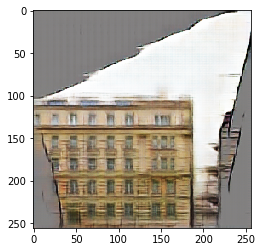

In [86]:
import matplotlib.pyplot as plt
z = z.reshape(256,256,3)
plt.imshow((z *127.5 +127.5).astype('uint8'))

In [87]:
train_y_ = train_y[k]
train_y_ = train_y_.reshape(256,256,3)

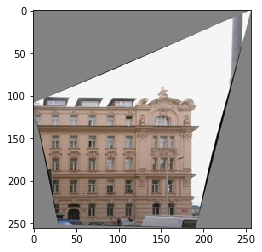

In [88]:
plt.imshow((train_y_ *127.5 +127.5).astype('uint8'))

In [84]:
pix2gen = keras.models.load_model("pix2gen.h5")
pix2dis = keras.models.load_model("pix2dis.h5")